# **Import Libraries**

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import random
%matplotlib inline
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers
from pathlib import Path

# **EDA**

In [2]:
# Menampilkan jumlah konten yang ada di folder

for dirpath, dirnames, filenames in os.walk("sport_classification"):
  print(f"Ada {len(dirnames)} folder dan {len(filenames)} gambar di direktori {dirpath}")

Ada 3 folder dan 0 gambar di direktori sport_classification
Ada 8 folder dan 0 gambar di direktori sport_classification\test
Ada 0 folder dan 5 gambar di direktori sport_classification\test\baseball
Ada 0 folder dan 5 gambar di direktori sport_classification\test\basketball
Ada 0 folder dan 5 gambar di direktori sport_classification\test\cricket
Ada 0 folder dan 5 gambar di direktori sport_classification\test\football
Ada 0 folder dan 5 gambar di direktori sport_classification\test\rugby
Ada 0 folder dan 5 gambar di direktori sport_classification\test\table tennis
Ada 0 folder dan 5 gambar di direktori sport_classification\test\tennis
Ada 0 folder dan 5 gambar di direktori sport_classification\test\volleyball
Ada 8 folder dan 0 gambar di direktori sport_classification\train
Ada 0 folder dan 156 gambar di direktori sport_classification\train\baseball
Ada 0 folder dan 139 gambar di direktori sport_classification\train\basketball
Ada 0 folder dan 130 gambar di direktori sport_classificati

Pada folder yang digunakan terdapat: 
- baseball: test= 5 gambar, train= 156 gambar, dan valid= 35
- basketball: test= 5 gambar, train= 139 gambar, dan valid= 35 
- cricket: test= 5 gambar, train= 130 gambar, dan valid= 27
- football: test= 5 gambar, train= 157 gambar, dan valid= 39
- rugby: test= 5 gambar, train= 137 gambar, dan valid= 34
- tennis: test= 5 gambar, train= 109 gambar, dan valid= 27 

## Get the data label

In [3]:
# Untuk melihat label yang akan digunakan dalam model nanti

data_dir = pathlib.Path("sport_classification/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['baseball' 'basketball' 'cricket' 'football' 'rugby' 'table tennis'
 'tennis' 'volleyball']


Data memiliki 8 kelas yang terdiri dari jenis-jenis olahraga baseball, baskeball, cricket, football, rugby, table tennis, tennis, dan vollyball

## Show Image

Ukuran Gambar: (224, 224, 3)


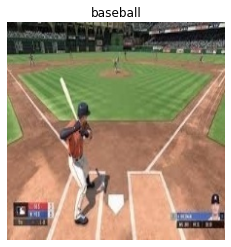

In [4]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Ukuran Gambar: {img.shape}")
  return img

img = view_random_image(target_dir='sport_classification/train/',
                        target_class='baseball')

In [5]:
train_dir='sport_classification/train'
species_list= sorted(os.listdir(train_dir))

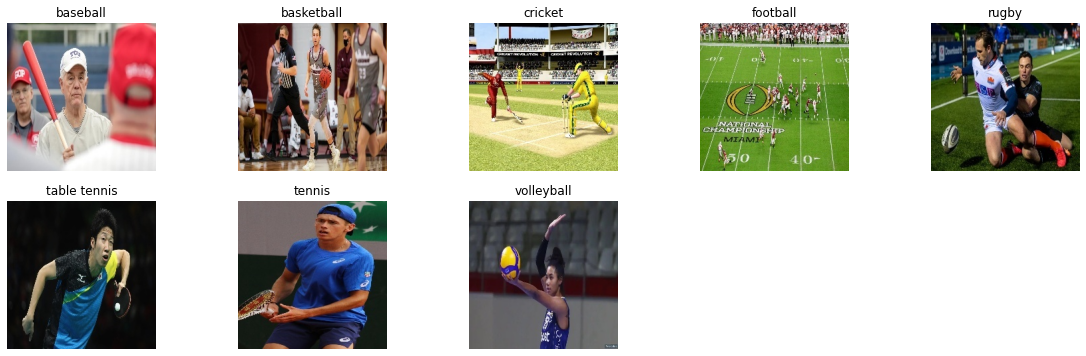

In [6]:
# Melihat gambar pertama dari data train

train_dir='sport_classification/train'
classes=len(os.listdir(train_dir))
fig = plt.figure(figsize=(20,6))
if classes % 5==0:
    rows=int(classes/5)
else:
    rows=int(classes/5) +1
for row in range(rows):
    for column in range(5):
        i= row * 5 + column 
        if i>classes-1:
            break            
        specie=species_list[i]
        species_path=os.path.join(train_dir, specie)
        f_path=os.path.join(species_path, '001.jpg')        
        img = mpimg.imread(f_path)
        a = fig.add_subplot(rows, 5, i+1)
        imgplot=plt.imshow(img)
        a.axis("off")
        a.set_title(specie)	

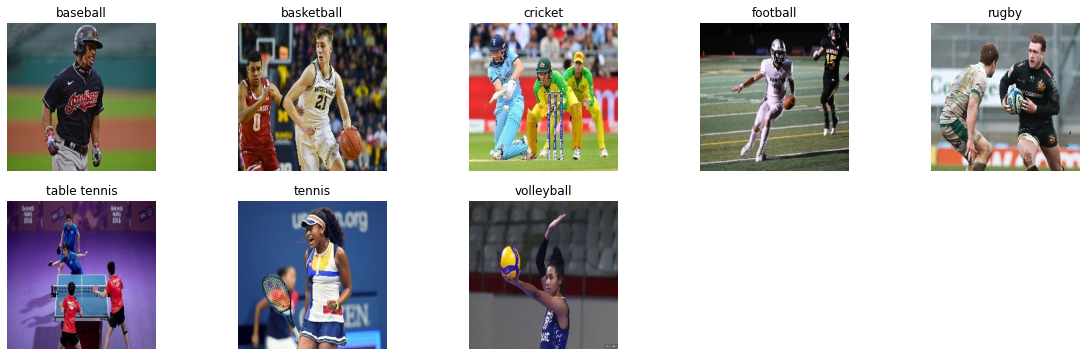

In [7]:
# Untuk melihat gambar pertama dari masing-masing folder valid

val_dir='sport_classification/valid'
classes=len(os.listdir(val_dir))
fig = plt.figure(figsize=(20,6))
if classes % 5==0:
    rows=int(classes/5)
else:
    rows=int(classes/5) +1
for row in range(rows):
    for column in range(5):
        i= row * 5 + column 
        if i>classes-1:
            break            
        specie=species_list[i]
        species_path=os.path.join(val_dir, specie)
        f_path=os.path.join(species_path, '1.jpg')        
        img = mpimg.imread(f_path)
        a = fig.add_subplot(rows, 5, i+1)
        imgplot=plt.imshow(img)
        a.axis("off")
        a.set_title(specie)	

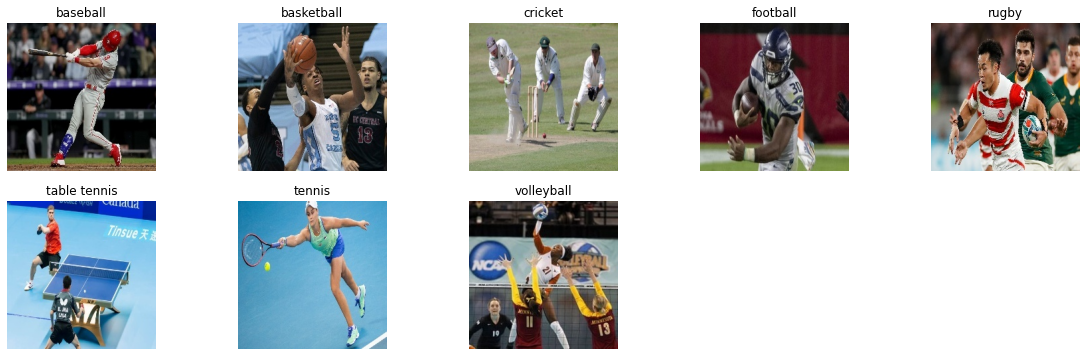

In [8]:
# # Untuk melihat gambar pertama dari masing-masing folder test

test_dir='sport_classification/test'
classes=len(os.listdir(test_dir))
fig = plt.figure(figsize=(20,6))
if classes % 5==0:
    rows=int(classes/5)
else:
    rows=int(classes/5) +1
for row in range(rows):
    for column in range(5):
        i= row * 5 + column 
        if i>classes-1:
            break            
        specie=species_list[i]
        species_path=os.path.join(test_dir, specie)
        f_path=os.path.join(species_path, '1.jpg')        
        img = mpimg.imread(f_path)
        a = fig.add_subplot(rows, 5, i+1)
        imgplot=plt.imshow(img)
        a.axis("off")
        a.set_title(specie)	

# **Data Loading**

In [9]:
tf.random.set_seed(33)

# Deklarasi objek
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# set data generator
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=33)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=33)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=33)

test_data = test_datagen.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size=(224,224),
                                            class_mode='categorical',
                                            seed=33)

Found 1067 images belonging to 8 classes.
Found 1067 images belonging to 8 classes.
Found 256 images belonging to 8 classes.
Found 40 images belonging to 8 classes.


# **Model Definition**

In [10]:
model = Sequential([
        Conv2D(100, 3, activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),), 
        Dropout(rate=0.01),
        MaxPool2D(2),
        Conv2D(100, 3, activation='relu'),
        Dropout(rate=0.01),
        MaxPool2D(2),
        Conv2D(50, 3, activation='relu'),
        Dropout(rate=0.01),
        Flatten(),
        Dense(8, activation='softmax')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 100)     2800      
                                                                 
 dropout (Dropout)           (None, 222, 222, 100)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 100)     90100     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 100)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 100)      0         
 2D)                                                    

# **Model Training**

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(),
              metrics=['accuracy'])

lurusbetlurus = model.fit(train_data_augmented,
                    epochs=20,
                    validation_data=valid_data,
                    verbose= 1)

Epoch 1/20
34/34 [==============================] - 125s 4s/step - loss: 2.0520 - accuracy: 0.2127 - val_loss: 1.8724 - val_accuracy: 0.1953
Epoch 2/20
34/34 [==============================] - 122s 4s/step - loss: 1.7524 - accuracy: 0.3393 - val_loss: 1.7196 - val_accuracy: 0.3711
Epoch 3/20
34/34 [==============================] - 116s 3s/step - loss: 1.6566 - accuracy: 0.3936 - val_loss: 1.5956 - val_accuracy: 0.4570
Epoch 4/20
34/34 [==============================] - 120s 4s/step - loss: 1.5520 - accuracy: 0.4396 - val_loss: 1.7694 - val_accuracy: 0.3867
Epoch 5/20
34/34 [==============================] - 124s 4s/step - loss: 1.5272 - accuracy: 0.4330 - val_loss: 1.5426 - val_accuracy: 0.4102
Epoch 6/20
34/34 [==============================] - 117s 3s/step - loss: 1.4850 - accuracy: 0.4480 - val_loss: 1.4016 - val_accuracy: 0.5078
Epoch 7/20
34/34 [==============================] - 114s 3s/step - loss: 1.3884 - accuracy: 0.5033 - val_loss: 1.4158 - val_accuracy: 0.4844
Epoch 8/20
34

<AxesSubplot:>

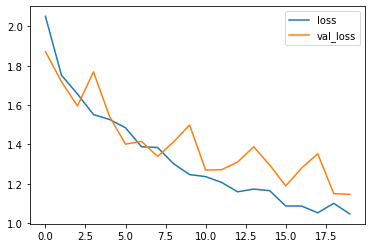

In [12]:
metrics = pd.DataFrame(lurusbetlurus.history)
metrics[['loss', 'val_loss']].plot()

- Pada val_loss (data validasi) terjadi exploading gradient (spike)
- Spike pada data validasi menunjukkan bahwa data tidak representatif, atau bisa dibilang data validasi yang digunakan tidak cukup untuk memberikan informasi dari masing-masing kelas.
- Berdasarkan nilai loss-nya ada beberapa epoch yang menunjukkan nilai overfit dan ada beberapa yang menunjukkan nilai underfit. 

<AxesSubplot:>

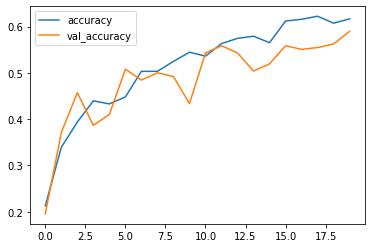

In [13]:
metrics[['accuracy', 'val_accuracy']].plot()

- Begitu pun dengan nilai akurasi, terdapat exploding gradient pada data validasi
- Sama seperti pada nilai los, untuk akurasi pada data vaidasi mengalami spike, sehingga dapat dibilang juga data validasi kurang memberikan informasi pada masing-masing kelas
- Berdasarkan nilai akurasinya bisa dibilang model menunjukkan overfitting. 

# **Model Evaluation**

In [14]:
#  Fungsi untuk memproses gambar yang belum memiliki ukuran 224x224

def load_and_preprocess(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

## Baseball

In [15]:
test_img_baseball_1 = mpimg.imread('sport_classification/test/baseball/1.jpg')
test_img_baseball_2 = mpimg.imread('sport_classification/test/baseball/2.jpg')
test_img_baseball_3 = mpimg.imread('sport_classification/test/baseball/3.jpg')
test_img_baseball_4 = mpimg.imread('sport_classification/test/baseball/4.jpg')
test_img_baseball_5 = mpimg.imread('sport_classification/test/baseball/5.jpg')

base_list = [test_img_baseball_1,test_img_baseball_2,test_img_baseball_3,test_img_baseball_4,test_img_baseball_5]

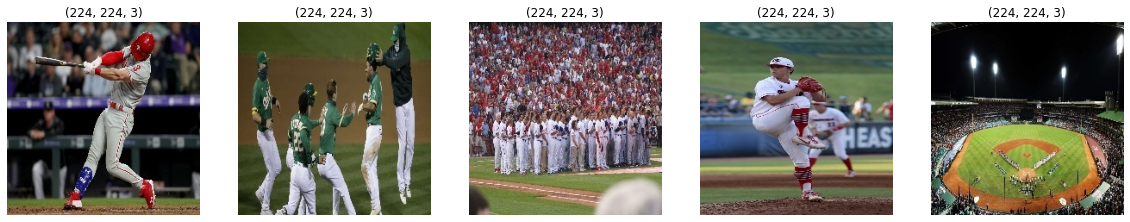

In [16]:
plt.figure(figsize=(20,6))
for i in range (len(base_list)):
    plt.subplot(1,5,i+1)
    plt.imshow(base_list[i])
    plt.title(base_list[i].shape)
    plt.axis(False)

Ukuran gambar sudah sesuai, yaitui 224 x 224 sehingga tidak perlu dilakukan load_and_preprocess

In [17]:
train_data.class_indices

{'baseball': 0,
 'basketball': 1,
 'cricket': 2,
 'football': 3,
 'rugby': 4,
 'table tennis': 5,
 'tennis': 6,
 'volleyball': 7}

In [18]:
label= ['baseball','basketball', 'cricket', 'football', 'rugby', 'table tennis','tennis', 'volleyball']

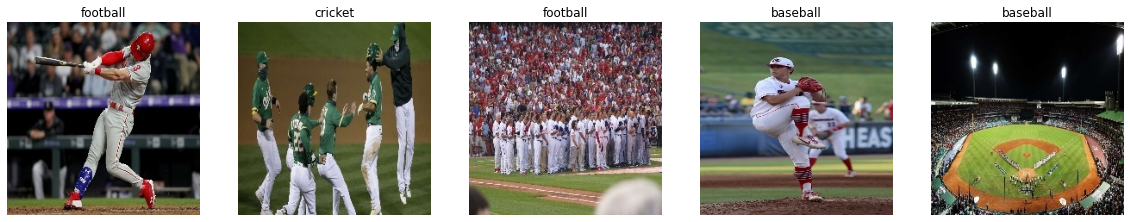

In [19]:
plt.figure(figsize=(20,6))
for i in range (len(base_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(base_list[i], axis=0)
    res= model.predict(img).argmax()
    plt.imshow(base_list[i])
    plt.title(label[res])
    plt.axis(False)

plt.show()

Dari 5 gambar test, model hanya berhasil mengenali 2 gambar, yaitu gambar ke-4 dan 5

## Cricket

In [20]:
test_img_cricket_1 = mpimg.imread('sport_classification/test/cricket/1.jpg')
test_img_cricket_2 = mpimg.imread('sport_classification/test/cricket/2.jpg')
test_img_cricket_3 = mpimg.imread('sport_classification/test/cricket/3.jpg')
test_img_cricket_4 = mpimg.imread('sport_classification/test/cricket/4.jpg')
test_img_cricket_5 = mpimg.imread('sport_classification/test/cricket/5.jpg')

cricket_list = [test_img_cricket_1, test_img_cricket_2, test_img_cricket_3, test_img_cricket_4, test_img_cricket_5]

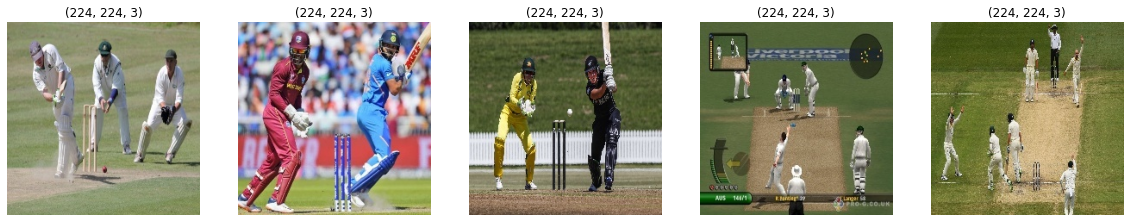

In [21]:
plt.figure(figsize=(20,6))
for i in range (len(cricket_list)):
    plt.subplot(1,5,i+1)
    plt.imshow(cricket_list[i])
    plt.title(cricket_list[i].shape)
    plt.axis(False)

Ukuran gambar sudah sesuai, yaitui 224 x 224 sehingga tidak perlu dilakukan load_and_preprocess

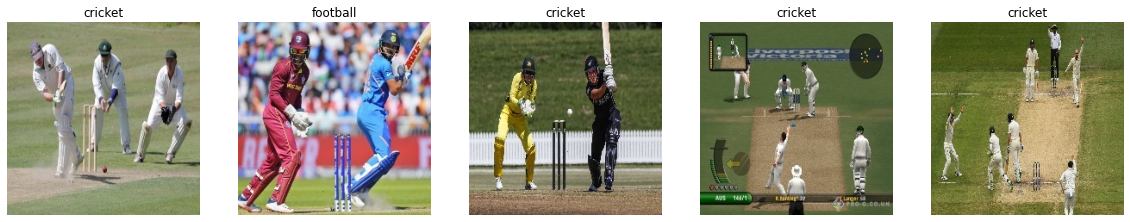

In [22]:
plt.figure(figsize=(20,6))
for i in range (len(cricket_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(cricket_list[i], axis=0)
    res= model.predict(img).argmax()
    plt.imshow(cricket_list[i])
    plt.title(label[res])
    plt.axis(False)

plt.show()

Model cukup baik dalam mengenali data test, dari 5 gambar model berhasil memprediksi dengan benar 4 gambar, yaitu gambar ke 1,3,4,5

## Football

In [23]:
test_img_football_1 = mpimg.imread('sport_classification/test/football/1.jpg')
test_img_football_2 = mpimg.imread('sport_classification/test/football/2.jpg')
test_img_football_3 = mpimg.imread('sport_classification/test/football/3.jpg')
test_img_football_4 = mpimg.imread('sport_classification/test/football/4.jpg')
test_img_football_5 = mpimg.imread('sport_classification/test/football/5.jpg')

football_list = [test_img_football_1,test_img_football_2,test_img_football_3,test_img_football_4,test_img_football_5]


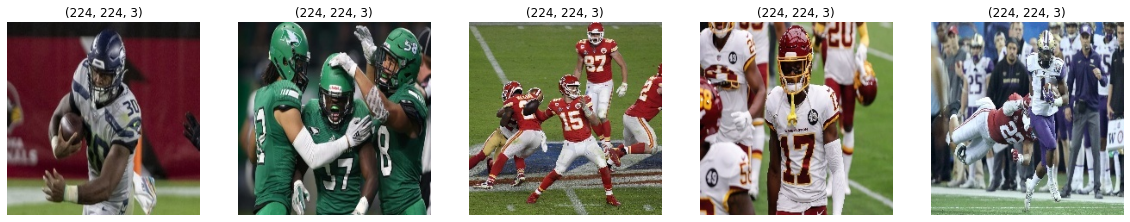

In [24]:
plt.figure(figsize=(20,6))
for i in range (len(football_list)):
    plt.subplot(1,5,i+1)
    plt.imshow(football_list[i])
    plt.title(football_list[i].shape)
    plt.axis(False)

Ukuran gambar sudah sesuai, yaitui 224 x 224 sehingga tidak perlu dilakukan load_and_preprocess

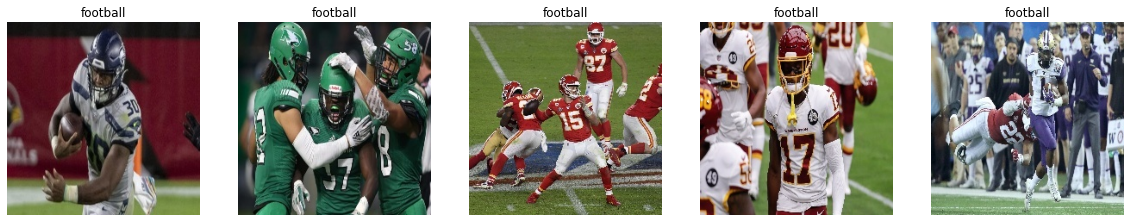

In [25]:
plt.figure(figsize=(20,6))
for i in range (len(football_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(football_list[i], axis=0)
    res= model.predict(img).argmax()
    plt.imshow(football_list[i])
    plt.title(label[res])
    plt.axis(False)

plt.show()

Dari 5 gambar test, model berhasil memprediksi semua gambar dengan benar

## Rugby

In [26]:
test_img_rugby_1 = mpimg.imread('sport_classification/test/rugby/1.jpg')
test_img_rugby_2 = mpimg.imread('sport_classification/test/rugby/2.jpg')
test_img_rugby_3 = mpimg.imread('sport_classification/test/rugby/3.jpg')
test_img_rugby_4 = mpimg.imread('sport_classification/test/rugby/4.jpg')
test_img_rugby_5 = mpimg.imread('sport_classification/test/rugby/5.jpg')

rugby_list= [test_img_rugby_1,test_img_rugby_2,test_img_rugby_3,test_img_rugby_4,test_img_rugby_5]

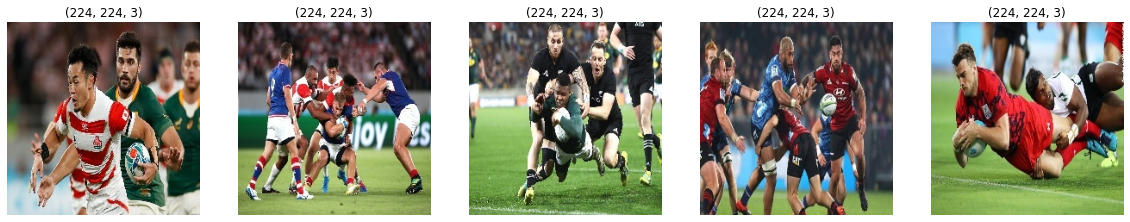

In [27]:
plt.figure(figsize=(20,6))
for i in range (len(rugby_list)):
    plt.subplot(1,5,i+1)
    plt.imshow(rugby_list[i])
    plt.title(rugby_list[i].shape)
    plt.axis(False)

Ukuran gambar sudah sesuai, yaitui 224 x 224 sehingga tidak perlu dilakukan load_and_preprocess

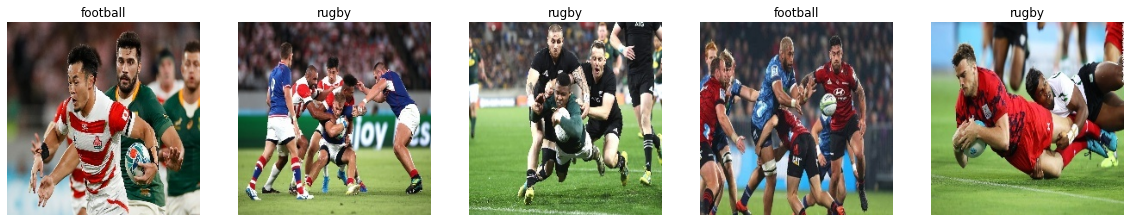

In [28]:
plt.figure(figsize=(20,6))
for i in range (len(rugby_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(rugby_list[i], axis=0)
    res= model.predict(img).argmax()
    plt.imshow(rugby_list[i])
    plt.title(label[res])
    plt.axis(False)

Dari 5 gambar test, model berhasil memprediksi dengan benar 3 gambar, yaitu data ke 2,3,5 

# **Pretrain Model**

## Model Definition 

In [29]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(Dense(133, activation='relu'))
mobilenet_model.add(Dropout(0.1))
mobilenet_model.add(Dense(133, activation='relu'))
mobilenet_model.add(Dropout(0.1))
mobilenet_model.add(Dense(133, activation='relu'))
mobilenet_model.add(Dropout(0.1))
mobilenet_model.add(Dense(8, activation='softmax'))

In [30]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 133)               170373    
                                                                 
 dropout (Dropout)           (None, 133)               0         
                                                                 
 dense_1 (Dense)             (None, 133)               17822     
                                                                 
 dropout_1 (Dropout)         (None, 133)               0

## Model Training 

In [31]:
mobilenet_model.compile(optimizer=Nadam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
menuju_hasil_yg_lbh_baik = mobilenet_model.fit(train_data_augmented,
                            epochs=20,
                            validation_data=valid_data,
                            verbose=1)  

Epoch 1/20
34/34 [==============================] - 25s 667ms/step - loss: 2.0747 - accuracy: 0.1715 - val_loss: 1.9605 - val_accuracy: 0.2539
Epoch 2/20
34/34 [==============================] - 23s 669ms/step - loss: 1.9166 - accuracy: 0.2774 - val_loss: 1.7866 - val_accuracy: 0.4883
Epoch 3/20
34/34 [==============================] - 22s 658ms/step - loss: 1.7173 - accuracy: 0.4096 - val_loss: 1.5257 - val_accuracy: 0.6445
Epoch 4/20
34/34 [==============================] - 22s 639ms/step - loss: 1.5039 - accuracy: 0.5023 - val_loss: 1.2620 - val_accuracy: 0.7266
Epoch 5/20
34/34 [==============================] - 22s 651ms/step - loss: 1.2834 - accuracy: 0.5886 - val_loss: 1.0286 - val_accuracy: 0.7695
Epoch 6/20
34/34 [==============================] - 22s 643ms/step - loss: 1.0911 - accuracy: 0.6514 - val_loss: 0.8550 - val_accuracy: 0.8086
Epoch 7/20
34/34 [==============================] - 22s 651ms/step - loss: 0.9458 - accuracy: 0.7057 - val_loss: 0.7084 - val_accuracy: 0.8203

<AxesSubplot:>

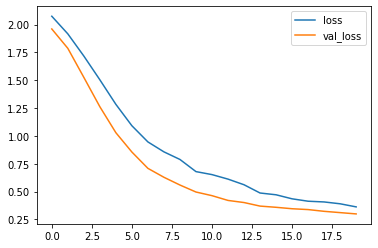

In [32]:
metrics_2 = pd.DataFrame(menuju_hasil_yg_lbh_baik.history)
metrics_2[['loss', 'val_loss']].plot()

- Angka loss meunjukkan penurunan yang baik pada setiap epochnya
- Namun pada nilai loss ini menunjukkan adanya underfitting, karena nilai loss data validasi lebih kecil dibandingkan data train

<AxesSubplot:>

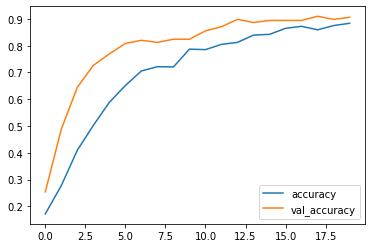

In [33]:
metrics_2[['accuracy', 'val_accuracy']].plot()

- Begitu pun pada nilai akurasinya, terjadi underfitting karena nilai akurasi dari data validadsi lebih besar dibandingkan data train

# **Model Evaluation Transfer Learning**

## Baseball

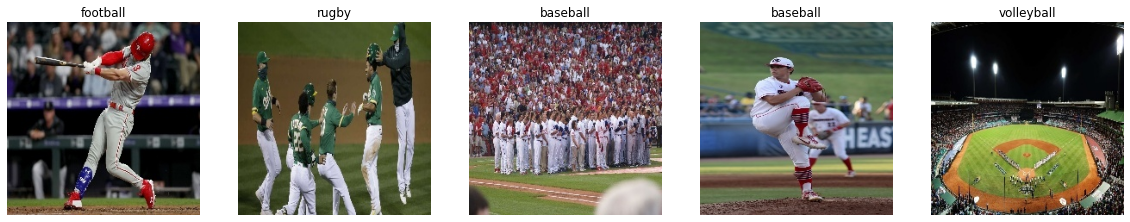

In [34]:
plt.figure(figsize=(20,6))
for i in range (len(base_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(base_list[i], axis=0)
    res= mobilenet_model.predict(img).argmax()
    plt.imshow(base_list[i])
    plt.title(label[res])
    plt.axis(False)

plt.show()

Dari 5 gambar test model hanya mampu memprediksi dengan benar pada gambar ke 3 dan 4

## Cricket

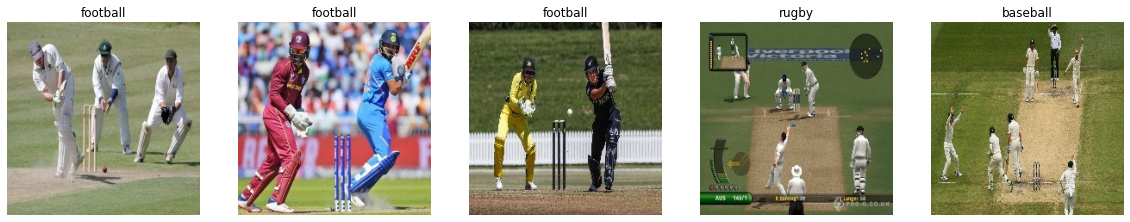

In [35]:
plt.figure(figsize=(20,6))
for i in range (len(cricket_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(cricket_list[i], axis=0)
    res= mobilenet_model.predict(img).argmax()
    plt.imshow(cricket_list[i])
    plt.title(label[res])
    plt.axis(False)

plt.show()

Tidak ada gambar yang di prediksi dengan benar oleh model

## Football

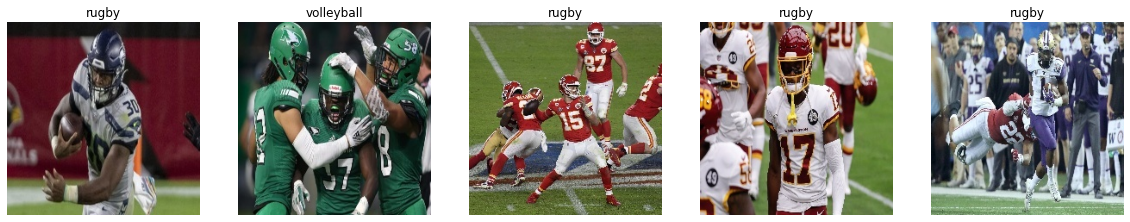

In [36]:
plt.figure(figsize=(20,6))
for i in range (len(football_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(football_list[i], axis=0)
    res= mobilenet_model.predict(img).argmax()
    plt.imshow(football_list[i])
    plt.title(label[res])
    plt.axis(False)

plt.show()

Tidak ada gambar yang diprediksi dengan benar oleh model

## Rugby

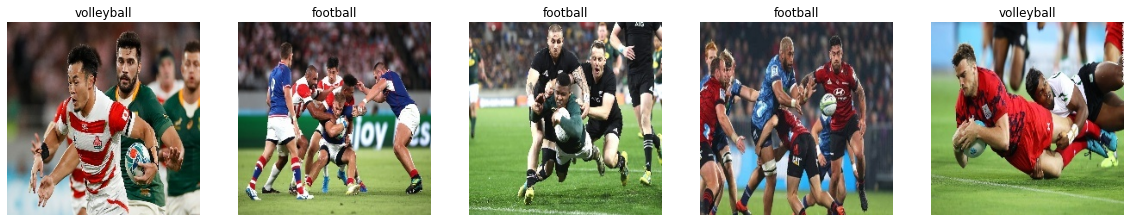

In [37]:
plt.figure(figsize=(20,6))
for i in range (len(rugby_list)):
    plt.subplot(1,5,i+1)
    img = expand_dims(rugby_list[i], axis=0)
    res= mobilenet_model.predict(img).argmax()
    plt.imshow(rugby_list[i])
    plt.title(label[res])
    plt.axis(False)

plt.show()

Tidak ada gambar yang diprediksi dengan benar oleh model

# **Model Inference**

In [40]:
inf_img_baseball = mpimg.imread('IMG_0503.jpg')
inf_img_basket = mpimg.imread('ofo1yb7yy0k2nqhffegy.jpg')
inf_img_cricket = mpimg.imread('Virat-Kohli-16092021-PTI-KunalPatil-1200.jpg')
inf_img_football = mpimg.imread('FBN_BRONCOS_PANTHERS_52.jpg')
inf_img_rugby = mpimg.imread('New_Zealand_vs_South_Africa_2006_Tri_Nations_Line_Out.jpg')
inf_img_tennis = mpimg.imread('u05vmqmbnnl0fltdtnmf.jpg')

inf_list = [inf_img_baseball, inf_img_basket, inf_img_cricket, inf_img_football, inf_img_rugby,inf_img_tennis]

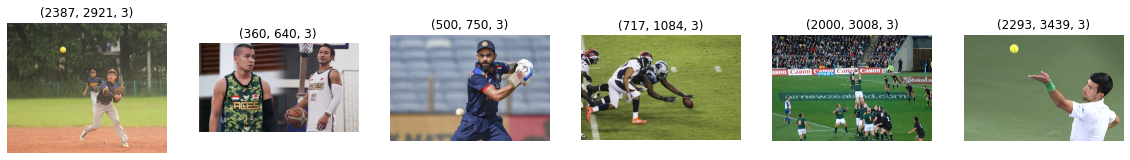

In [41]:
plt.figure(figsize=(20,6))
for i in range (len(inf_list)):
    plt.subplot(1,6,i+1)
    plt.imshow(inf_list[i])
    plt.title(inf_list[i].shape)
    plt.axis(False)

setiap gambar infrence memiliki ukuran yang berbeda sehingga perlu dilakukan resize

In [42]:
inf_img_baseball = load_and_preprocess ('IMG_0503.jpg')
inf_img_basket = load_and_preprocess ('ofo1yb7yy0k2nqhffegy.jpg')
inf_img_cricket = load_and_preprocess ('Virat-Kohli-16092021-PTI-KunalPatil-1200.jpg')
inf_img_football = load_and_preprocess ('FBN_BRONCOS_PANTHERS_52.jpg')
inf_img_rugby = load_and_preprocess ('New_Zealand_vs_South_Africa_2006_Tri_Nations_Line_Out.jpg')
inf_img_tennis = load_and_preprocess ('u05vmqmbnnl0fltdtnmf.jpg')

In [43]:
inf_list_gas= [inf_img_baseball,inf_img_basket,inf_img_cricket,inf_img_football,inf_img_rugby,inf_img_tennis]

## Inference test with Base Model

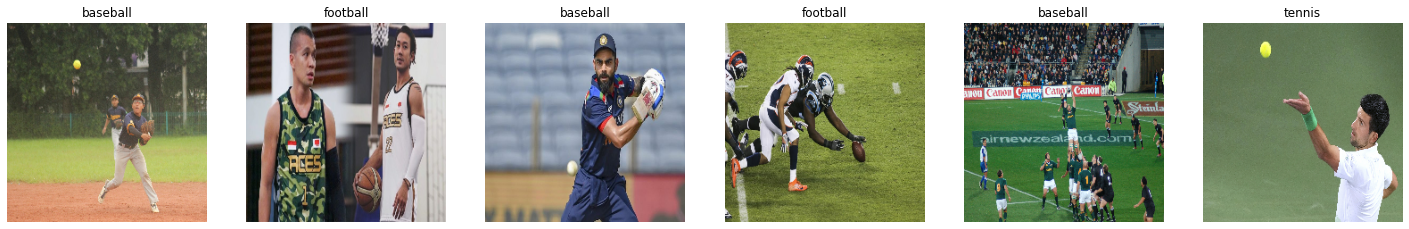

In [44]:
plt.figure(figsize=(25,6))
for i in range (len(inf_list_gas)):
    plt.subplot(1,6,i+1)
    img = expand_dims(inf_list_gas[i], axis=0)
    res= model.predict(img).argmax()
    plt.imshow(inf_list_gas[i])
    plt.title(label[res])
    plt.axis(False)

Dari 6 gambar inference, model salah memprediksi pada gambar ke 2, 3, dan 5

## Inference test with Pretrain Model

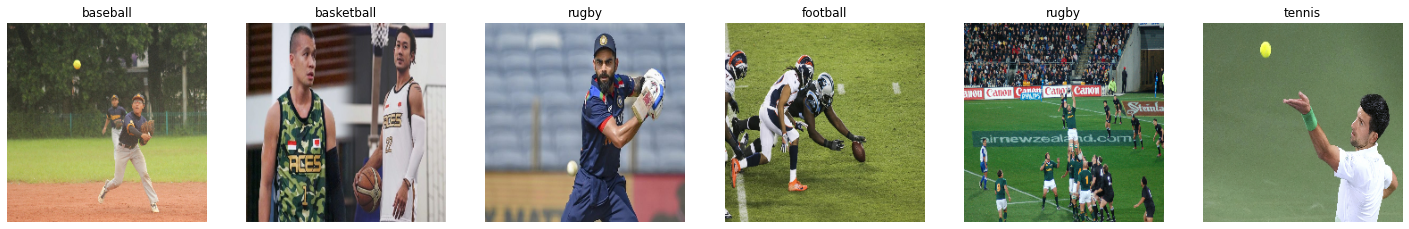

In [45]:
plt.figure(figsize=(25,6))
for i in range (len(inf_list_gas)):
    plt.subplot(1,6,i+1)
    img = expand_dims(inf_list_gas[i], axis=0)
    res= mobilenet_model.predict(img).argmax()
    plt.imshow(inf_list_gas[i])
    plt.title(label[res])
    plt.axis(False)

Model hanya salah dalam memprediksi gambar ke-3

# **Conclusion**

### Base Model

- Pada loss dan accuracy terjadi spike pada data validasi, yang menandakan bahwa data validasi kurang memberikan informasi pada setiap kelas.
- Terjadinya underfitting pada nilai loss dan overfitiing pada nilai akurasi
- Untuk meningkatkan tingkat accuracy, menurunkan nilai loss, undfittning, overfitting, dan spike (exploding gradient) kedepannya bisa dilakukan tuning lebih lanjut pada setiap hidden layerya, serta menambahkan data terutama pada data validasi agar bisa memberikan informasi lebih pada setiap kelasnya.  

### Pretrain

- Pada Pretrain model untuk nilai loss serta akurasinya engalami underfitting, dimana pada kedua nilai tersebut model lebih baik dalam mengenal data validasi dibandingkan data training
- Meskipun begitu akurasi dan loss yang diperoleh pada model ini dari segi angka bisa dibilang cukup baik dibandingkan dengan base model
- Namun saat melakukan prediksi terhadap data test yang sama saat dipakai dengan base model, model pretrain ini lebih sedikit memprediksi gambar dengan tepat dibandingkan dengan base model. Padahal apabila kita melihat nilai akurasi dan lossnya dari hasil pengujian, seharusnya model pretrain ini mampu memprediksi lebih banyak gambar dengan tepat dibandingkan base model.
- Sehingga dapat dikatakan, selain terjadi underfitting pada data validasi dan data train, juga terjadi overfitting pada data test, dimana akurasi model pada data test jauh lebih rendah dibandingkan data train. 
- Untuk mengatasi kasus overfitting ini kedepannya mungkin bisa dilakukan dengan beberapa tuning (improvement) pada model.  